In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
import astropy.units as u

import scipy.stats.distributions as dist

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
cos_dat_fold = 'E:/cosmos-data'

In [3]:
df_or_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full-rem-seps-z.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_or_cat

,ID,ORyanID_23,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,816891,4000705532455,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-1.043282e-05,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,860686,4000705533383,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,1.571297e-06,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,1301188,4000705539941,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-2.881107e-06,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,1304538,4000705540034,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-6.036952e-06,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,1310001,4000705540064,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-1.023530e-05,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,1520733,4001204758614_extra,stage4,149.891374,2.866981,28107.876953,37826.437500,0.000086,0.000104,-9.313976e-07,...,-9.441206,-9.279022,-9.095134,-9.003501,-8.955496,0.120441,0.213251,0.306832,0.556012,0.731876
3928,1520749,4546055995_extra,stage2,150.383110,2.865367,16320.103516,37787.917969,0.000131,0.000236,7.123858e-05,...,-9.857880,-9.658215,-9.485625,-9.235816,-8.971795,0.162147,0.238640,0.432004,0.592193,0.687256
3929,1523385,4000927318133_extra,stage3,149.789910,2.865132,30540.179688,37782.648438,0.000045,0.000059,1.600747e-05,...,-9.525900,-9.472779,-9.353454,-9.273221,-9.213521,0.262676,0.355466,0.410356,0.489105,0.566003
3930,1524909,4000747939904_extra,stage3,150.450581,2.872371,14702.710938,37956.468750,0.000248,0.000292,7.378556e-06,...,-9.556987,-9.385500,-9.154130,-9.026810,-8.938077,0.153294,0.283249,0.436332,0.600615,0.693621


In [5]:
df_or_noextra = (
    df_or_cat
    .assign(extra = df_or_cat.ORyanID_23.apply(lambda x: True if type(x) == str and 'extra' in str(x) else False))
    .query('extra == False')
)

In [6]:
df_or_cat.category.value_counts()

stage3    1437
stage2     972
stage1     801
stage4     722
Name: category, dtype: int64

In [7]:
df_or_noextra.category.value_counts()

stage3    1206
stage2     865
stage4     586
stage1     461
Name: category, dtype: int64

In [8]:
with fits.open(f'{cos_dat_fold}/VLA_3GHz_counterpart_array_20170210_paper_smolcic_et_al.fits') as hdul:
    smol_rec = hdul[1].data

In [9]:
def getting_smol_info(id_str, smol_rec):
    
    row = smol_rec[(smol_rec['ID_VLA'] == id_str)]
    if len(row) > 0:        
        if row['SFG'] == 'true':
            return 'SFG'
        else:
            return 'AGN'
    else:
        return np.nan

In [10]:
# Function that selects the closest object in the MPA_JHU as the galaxy of interest.
def get_correct_smolcic_id(ra, dec, tab):
    cosmos_coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')
    
    mpa_coords = SkyCoord(ra = tab['RA_VLA_J2000'] * u.deg, dec = tab['DEC_VLA_J2000'] * u.deg, frame = 'fk5')
    
    seps = list(abs((cosmos_coord.separation(mpa_coords)).to(u.arcsec) / u.arcsec))
    
    min_ind = seps.index(min(seps))
    
    return {'smol_ID' : int(tab['ID_VLA'][min_ind]), 'RA' : tab[min_ind]['RA_VLA_J2000'], 'Dec' : tab[min_ind]['DEC_VLA_J2000']}

In [11]:
def matching_smolcic_ids(ra, dec, smol_rec):
    arcsec_sep_deg = 1 / (60 * 60)
    
    matching_tab = smol_rec[(smol_rec['RA_VLA_J2000'] > ra - arcsec_sep_deg) & (smol_rec['RA_VLA_J2000'] < ra + arcsec_sep_deg) & (smol_rec['DEC_VLA_J2000'] > dec - arcsec_sep_deg) & (smol_rec['DEC_VLA_J2000'] < dec + arcsec_sep_deg)]
    if len(matching_tab) < 0.5:
        return {'smol_ID' : np.nan, 'RA' : np.nan, 'Dec' : np.nan}
    elif len(matching_tab) == 1:
        return {'smol_ID' : int(matching_tab['ID_VLA'][0]), 'RA' : matching_tab['RA_VLA_J2000'][0], 'Dec' : matching_tab['DEC_VLA_J2000'][0]}
    elif len(matching_tab) > 1:
        return get_correct_smolcic_id(ra, dec, matching_tab)
    else:
        print('Somethings gone very wrong!!')
        sys.exit()

In [12]:
coords_dict = (
    df_or_noextra[['ID', 'ALPHA_J2000', 'DELTA_J2000']]
    .rename(columns = {'ALPHA_J2000' : 'RA', 'DELTA_J2000' : 'DEC'})
    .set_index('ID').to_dict(orient = 'index')
)

In [13]:
smolcic_matched_dict = {}

In [14]:
done_ids = list(smolcic_matched_dict.keys())
for i in tqdm(list(coords_dict.keys())):
    if i in done_ids:
        continue
    
    smolcic_matched_dict[i] = matching_smolcic_ids(coords_dict[i]['RA'], coords_dict[i]['DEC'], smol_rec)

100%|██████████| 3118/3118 [00:17<00:00, 173.88it/s]


In [15]:
smolcic_df = pd.DataFrame.from_dict(smolcic_matched_dict, orient = 'index').dropna().reset_index().rename(columns = {'index' : 'ID'})

In [16]:
smolcic_df_clsfs = smolcic_df.assign(gal_clsf = smolcic_df.smol_ID.apply(lambda x: getting_smol_info(x, smol_rec))).drop_duplicates('smol_ID', keep = 'first')

In [17]:
smolcic_df_clsfs.gal_clsf.value_counts()

SFG    269
AGN     82
Name: gal_clsf, dtype: int64

In [18]:
smolcic_df_clsfs.drop_duplicates('smol_ID', keep = 'first').gal_clsf.value_counts()

SFG    269
AGN     82
Name: gal_clsf, dtype: int64

In [19]:
smolcic_no_red = smolcic_df_clsfs[['ID', 'gal_clsf']]

In [20]:
df_no_merged = (
    smolcic_no_red
    .merge(df_or_cat, on = 'ID', how = 'left')
)

In [21]:
df_no_merged

,ID,gal_clsf,ORyanID_23,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,844303,AGN,4000706649921,stage3,150.059115,2.219933,24087.431641,22296.068359,1.760487e-05,2.045168e-05,...,-9.125792,-8.891618,-8.577000,-8.342815,-8.276746,1.678882,1.798450,1.974514,2.120620,2.250814
1,230625,AGN,4000707047113,stage3,150.231845,1.627975,19943.902344,8088.662109,3.233492e-05,1.895889e-05,...,-10.733325,-10.606746,-10.378867,-9.887330,-9.657894,0.822825,0.878771,0.955453,1.114303,1.234099
2,250320,SFG,4000707049267,stage3,150.233391,1.651848,19906.861328,8661.684570,2.008575e-05,1.584788e-05,...,-9.879090,-9.509571,-9.250247,-9.072077,-8.900543,0.665933,0.893426,1.101838,1.288189,1.583752
3,509282,SFG,4000716471288,stage4,149.887117,1.908720,28213.458984,14827.238281,1.731534e-04,7.874386e-05,...,-10.428830,-10.298646,-10.107775,-9.738449,-9.533908,0.669421,0.823108,1.062129,1.202793,1.291477
4,541991,SFG,4000716472139,stage3,149.927294,1.938299,27249.621094,15537.033203,3.872015e-05,4.327236e-05,...,-10.323037,-10.240524,-10.102973,-9.976230,-9.923860,0.866347,0.953774,1.027753,1.128404,1.209716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,358919,SFG,6000511588261,stage3,150.248838,1.761441,19536.511719,11292.128906,3.388341e-05,2.419436e-05,...,-11.498836,-11.376282,-10.996401,-10.658434,-10.470866,1.027574,1.097931,1.131383,1.161948,1.181445
347,302055,SFG,6000529676819,stage2,149.672809,1.705123,33355.699219,9941.517578,1.032136e-05,6.374337e-06,...,-9.744911,-9.587836,-9.398809,-9.239985,-9.098722,0.681651,0.707942,0.767624,0.817824,0.880134
348,715824,SFG,6000534883051,stage1,150.224457,2.104780,20121.996094,19532.460938,7.730274e-06,8.491398e-06,...,-10.033968,-9.957228,-9.893579,-9.849008,-9.814916,0.876113,0.905105,0.998252,1.082617,1.142795
349,1016112,AGN,6000535008523,stage2,150.027738,2.373879,24839.683594,25990.814453,2.894171e-07,5.559183e-07,...,-13.550710,-13.550710,-13.540160,-13.528674,-13.520179,0.348619,0.376110,0.456763,0.527628,0.582440


In [22]:
df_no_red = df_no_merged[['ORyanID_23', 'ID', 'category', 'ID_COSMOS2015', 'gal_clsf']]

In [23]:
df_no_red

,ORyanID_23,ID,category,ID_COSMOS2015,gal_clsf
0,4000706649921,844303,stage3,607340,AGN
1,4000707047113,230625,stage3,230785,AGN
2,4000707049267,250320,stage3,244910,SFG
3,4000716471288,509282,stage4,405672,SFG
4,4000716472139,541991,stage3,425594,SFG
...,...,...,...,...,...
346,6000511588261,358919,stage3,312597,SFG
347,6000529676819,302055,stage2,278056,SFG
348,6000534883051,715824,stage1,529514,SFG
349,6000535008523,1016112,stage2,707132,AGN


In [24]:
df_dna = df_no_red.dropna()
df_dna

,ORyanID_23,ID,category,ID_COSMOS2015,gal_clsf
0,4000706649921,844303,stage3,607340,AGN
1,4000707047113,230625,stage3,230785,AGN
2,4000707049267,250320,stage3,244910,SFG
3,4000716471288,509282,stage4,405672,SFG
4,4000716472139,541991,stage3,425594,SFG
...,...,...,...,...,...
346,6000511588261,358919,stage3,312597,SFG
347,6000529676819,302055,stage2,278056,SFG
348,6000534883051,715824,stage1,529514,SFG
349,6000535008523,1016112,stage2,707132,AGN


In [25]:
df_dna.category.value_counts()

stage3    143
stage2     85
stage4     81
stage1     42
Name: category, dtype: int64

In [26]:
print(df_dna.query('category == "stage1"').gal_clsf.value_counts())
print('')
print(df_dna.query('category == "stage2"').gal_clsf.value_counts())
print('')
print(df_dna.query('category == "stage3"').gal_clsf.value_counts())
print('')
print(df_dna.query('category == "stage4"').gal_clsf.value_counts())

SFG    30
AGN    12
Name: gal_clsf, dtype: int64

SFG    64
AGN    21
Name: gal_clsf, dtype: int64

SFG    112
AGN     31
Name: gal_clsf, dtype: int64

SFG    63
AGN    18
Name: gal_clsf, dtype: int64


In [27]:
stage1_counts = df_dna.query('category == "stage1"').gal_clsf.value_counts()
stage2_counts = df_dna.query('category == "stage2"').gal_clsf.value_counts()
stage3_counts = df_dna.query('category == "stage3"').gal_clsf.value_counts()
stage4_counts = df_dna.query('category == "stage4"').gal_clsf.value_counts()

In [28]:
stage1_frac = stage1_counts['AGN'] / (stage1_counts['AGN'] + stage1_counts['SFG'])
stage2_frac = stage2_counts['AGN'] / (stage2_counts['AGN'] + stage2_counts['SFG'])
stage3_frac = stage3_counts['AGN'] / (stage3_counts['AGN'] + stage3_counts['SFG'])
stage4_frac = stage4_counts['AGN'] / (stage4_counts['AGN'] + stage4_counts['SFG'])

In [29]:
print(stage1_frac)
print(stage2_frac)
print(stage3_frac)
print(stage4_frac)

0.2857142857142857
0.24705882352941178
0.21678321678321677
0.2222222222222222


In [30]:
all_stage1_frac = stage1_counts['AGN'] / len(df_or_cat.query('category == "stage1"'))
all_stage2_frac = stage2_counts['AGN'] / len(df_or_cat.query('category == "stage2"'))
all_stage3_frac = stage3_counts['AGN'] / len(df_or_cat.query('category == "stage3"'))
all_stage4_frac = stage4_counts['AGN'] / len(df_or_cat.query('category == "stage4"'))

In [31]:
all_fracts = np.array([
    all_stage1_frac,
    all_stage2_frac,
    all_stage3_frac,
    all_stage4_frac
])

In [32]:
print(all_stage1_frac)
print(all_stage2_frac)
print(all_stage3_frac)
print(all_stage4_frac)

0.0149812734082397
0.021604938271604937
0.021572720946416143
0.024930747922437674


In [33]:
x = ['Separated', 'Pericentre', 'Apocentre','Merging']

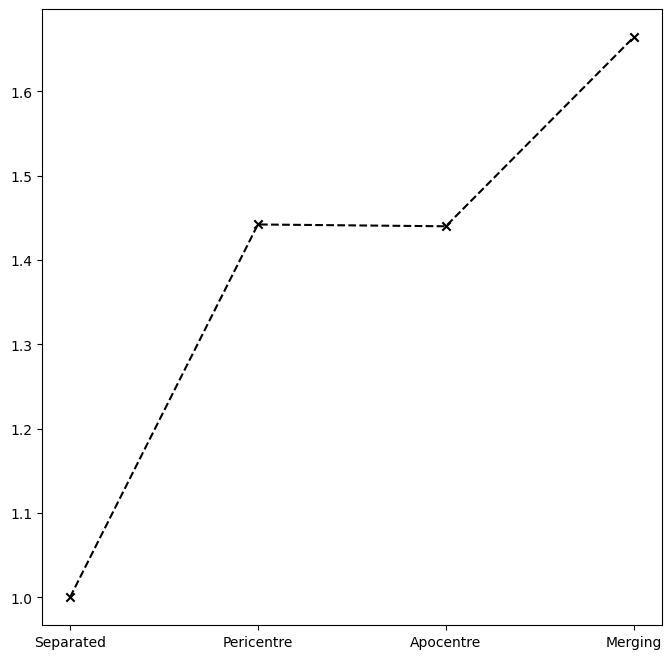

In [34]:
plt.figure(figsize = (8,8))
plt.scatter(x, all_fracts / all_fracts[0] , color = 'black', marker = 'x')
plt.plot(x, all_fracts / all_fracts[0], color = 'black', linestyle='--')
plt.show()

## Also Using Chandra

In [35]:
with fits.open(f'{cos_dat_fold}/chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits') as hdul:
    chandra_cat = hdul[1].data

In [36]:
# Function that selects the closest object in the MPA_JHU as the galaxy of interest.
def get_correct_chandra_id(ra, dec, tab):
    cosmos_coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')
    
    chandra_coords = SkyCoord(ra = tab['RA_x'] * u.deg, dec = tab['DEC_x'] * u.deg, frame = 'fk5')
    
    seps = list(abs((cosmos_coord.separation(chandra_coords)).to(u.arcsec) / u.arcsec))
    
    min_ind = seps.index(min(seps))
    
    return {'CHANDRA_ID' : tab[min_ind]['id_x'], 'RA' : tab[min_ind]['RA_x'], 'Dec' : tab[min_ind]['DEC_x']}

In [37]:
def matching_chandra_ids(ra, dec, chandra_cat):
    arcsec_sep_deg = 1 / (60 * 60)
    
    matching_tab = chandra_cat[(chandra_cat['RA_x'] > ra - arcsec_sep_deg) & (chandra_cat['RA_x'] < ra + arcsec_sep_deg) & (chandra_cat['DEC_x'] > dec - arcsec_sep_deg) & (chandra_cat['DEC_x'] < dec + arcsec_sep_deg)]
    if len(matching_tab) < 0.5:
        return {'CHANDRA_ID' : np.nan, 'RA' : np.nan, 'Dec' : np.nan}
    elif len(matching_tab) == 1:
        return {'CHANDRA_ID' : matching_tab['id_x'][0], 'RA' : matching_tab['RA_x'][0], 'Dec' : matching_tab['DEC_x'][0]}
    elif len(matching_tab) > 1:
        print('Multiple Options')
        return get_correct_chandra_id(ra, dec, matching_tab)
    else:
        print('Somethings gone very wrong!!')
        sys.exit()

In [38]:
df_tmp_merge = df_or_noextra[['ID', 'ALPHA_J2000', 'DELTA_J2000']].merge(df_dna, how = 'left', on = 'ID', indicator = True)

In [39]:
coords_dict_chand = (
    df_tmp_merge
    .query('_merge == "left_only"')
    [['ID', 'ALPHA_J2000', 'DELTA_J2000']]
    .rename(columns = {'ALPHA_J2000' : 'RA', 'DELTA_J2000' : 'DEC'})
    .set_index('ID')
    .to_dict(orient = 'index')
)

In [40]:
chandra_matched_dict = {}

In [41]:
done_ids = list(chandra_matched_dict.keys())
for i in tqdm(list(coords_dict_chand.keys())):
    if i in done_ids:
        continue
    
    chandra_matched_dict[i] = matching_chandra_ids(coords_dict_chand[i]['RA'], coords_dict_chand[i]['DEC'], chandra_cat)

100%|██████████| 2767/2767 [00:33<00:00, 81.77it/s]


In [42]:
chandra_df = pd.DataFrame.from_dict(chandra_matched_dict, orient = 'index').dropna()
len(chandra_df)

25

In [43]:
chandra_ids = chandra_df.reset_index().rename(columns = {'index': 'ID'})

In [44]:
smol_ids = list(df_dna.ID)

In [45]:
chandra_ids.assign(in_smol = chandra_ids.ID.apply(lambda x: True if x in smol_ids else False)).query('in_smol')

,ID,CHANDRA_ID,RA,Dec,in_smol


In [46]:
def getting_chandra_info(chandra_id, chandra_cat):
    row = chandra_cat[chandra_cat['id_x'] == chandra_id]    
    hard_lum = row['Lx_210'][0]
    
    if hard_lum <= 44:
        return 'SFG'
    elif hard_lum > 44:
        return 'AGN'
    else:
        return np.nan

In [47]:
chandra_clsfs = (
    chandra_ids
    .assign(gal_clsf = chandra_ids.CHANDRA_ID.apply(lambda x: getting_chandra_info(x, chandra_cat)))
)

In [48]:
chandra_clsfs.gal_clsf.value_counts()

SFG    25
Name: gal_clsf, dtype: int64

In [49]:
chandra_or_cat = (
    chandra_clsfs
    .merge(df_or_cat, on = 'ID', how = 'left')
    [['ORyanID_23', 'ID', 'category', 'ID_COSMOS2015', 'gal_clsf']]
)

In [50]:
df_combined = (
    pd.concat([df_dna, chandra_or_cat])
    .drop_duplicates('ID_COSMOS2015', keep='last')
)

In [51]:
print(df_combined.query('category == "stage1"').gal_clsf.value_counts())
print('')
print(df_combined.query('category == "stage2"').gal_clsf.value_counts())
print('')
print(df_combined.query('category == "stage3"').gal_clsf.value_counts())
print('')
print(df_combined.query('category == "stage4"').gal_clsf.value_counts())

SFG    38
AGN    12
Name: gal_clsf, dtype: int64

SFG    66
AGN    21
Name: gal_clsf, dtype: int64

SFG    124
AGN     31
Name: gal_clsf, dtype: int64

SFG    64
AGN    18
Name: gal_clsf, dtype: int64


In [52]:
stage1_counts_cha = df_combined.query('category == "stage1"').gal_clsf.value_counts()
stage2_counts_cha = df_combined.query('category == "stage2"').gal_clsf.value_counts()
stage3_counts_cha = df_combined.query('category == "stage3"').gal_clsf.value_counts()
stage4_counts_cha = df_combined.query('category == "stage4"').gal_clsf.value_counts()

In [53]:
stage1_frac_cha = stage1_counts_cha['AGN'] / (stage1_counts_cha['AGN'] + stage1_counts_cha['SFG'])
stage2_frac_cha = stage2_counts_cha['AGN'] / (stage2_counts_cha['AGN'] + stage2_counts_cha['SFG'])
stage3_frac_cha = stage3_counts_cha['AGN'] / (stage3_counts_cha['AGN'] + stage3_counts_cha['SFG'])
stage4_frac_cha = stage4_counts_cha['AGN'] / (stage4_counts_cha['AGN'] + stage4_counts_cha['SFG'])

In [54]:
print(stage1_frac_cha)
print(stage2_frac_cha)
print(stage3_frac_cha)
print(stage4_frac_cha)

0.24
0.2413793103448276
0.2
0.21951219512195122


In [55]:
all_stage1_frac = stage1_counts_cha['AGN'] / len(df_or_noextra.query('category == "stage1"'))
all_stage2_frac = stage2_counts_cha['AGN'] / len(df_or_noextra.query('category == "stage2"'))
all_stage3_frac = stage3_counts_cha['AGN'] / len(df_or_noextra.query('category == "stage3"'))
all_stage4_frac = stage4_counts_cha['AGN'] / len(df_or_noextra.query('category == "stage4"'))

In [56]:
all_fracts = np.array([
    all_stage1_frac,
    all_stage2_frac,
    all_stage3_frac,
    all_stage4_frac
])

In [57]:
print(all_stage1_frac)
print(all_stage2_frac)
print(all_stage3_frac)
print(all_stage4_frac)

0.026030368763557483
0.024277456647398842
0.02570480928689884
0.030716723549488054


In [58]:
x = ['Separated', 'Pericentre', 'Apocentre','Merging']

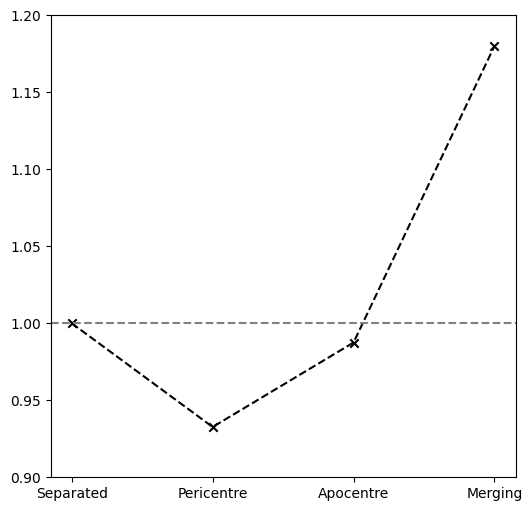

In [59]:
plt.figure(figsize = (6,6))
plt.scatter(x, all_fracts / all_fracts[0] , color = 'black', marker = 'x')
plt.plot(x, all_fracts / all_fracts[0], color = 'black', linestyle='--')
plt.axhline(1.0, color = 'gray', linestyle = '--')
plt.ylim([0.90,1.20])
plt.show()

## Calculating the Errors

In [62]:
def lower_beta(c,k,n):
    return dist.beta.ppf((1-c)/2, k+1, n-k+1)

In [63]:
def upper_beta(c,k,n):
    return dist.beta.ppf(1-(1-c)/2, k+1, n-k+1)

In [183]:
agn_s1_upper = upper_beta(0.683, stage1_counts_cha['AGN'] , len(df_or_noextra.query('category == "stage1"'))) - all_fracts[0]
agn_s1_lower = all_fracts[0] - lower_beta(0.683, stage1_counts_cha['AGN'] , len(df_or_noextra.query('category == "stage1"')))

agn_s2_upper = upper_beta(0.683, stage2_counts_cha['AGN'] , len(df_or_noextra.query('category == "stage2"'))) - all_stage2_frac
agn_s2_lower = all_stage2_frac - lower_beta(0.683, stage2_counts_cha['AGN'] , len(df_or_noextra.query('category == "stage2"')))

agn_s3_upper = upper_beta(0.683, stage3_counts_cha['AGN'] , len(df_or_noextra.query('category == "stage3"'))) - all_stage3_frac
agn_s3_lower = all_stage3_frac - lower_beta(0.683, stage3_counts_cha['AGN'] , len(df_or_noextra.query('category == "stage3"')))

agn_s4_upper = upper_beta(0.683, stage4_counts_cha['AGN'] , len(df_or_noextra.query('category == "stage4"'))) - all_stage4_frac
agn_s4_lower = all_stage4_frac - lower_beta(0.683, stage4_counts_cha['AGN'] , len(df_or_noextra.query('category == "stage4"')))

In [184]:
agn_frac_err = np.array([
    [agn_s1_lower, agn_s1_upper],
    [agn_s2_lower, agn_s2_upper],
    [agn_s3_lower, agn_s3_upper],
    [agn_s4_lower, agn_s4_upper]
])

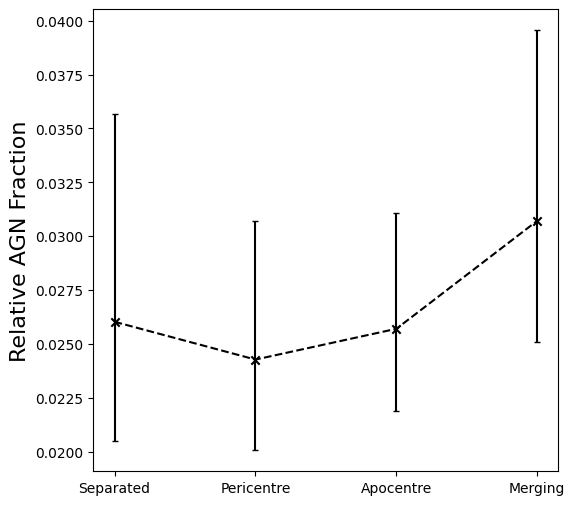

In [185]:
plt.figure(figsize = (6,6))
plt.scatter(x, all_fracts , color = 'black', marker = 'x')
plt.plot(x, all_fracts, color = 'black', linestyle='--')
# plt.axhli}ne(1.0, color = 'gray', linestyle = '--')
plt.errorbar(x, all_fracts, yerr=agn_frac_err.T, linestyle = '', color='black', barsabove=True, capsize=2.5)
# plt.ylim([0.90,1.20])
plt.ylabel('Relative AGN Fraction', fontsize = 16)
# plt.savefig(f'{}')
plt.show()

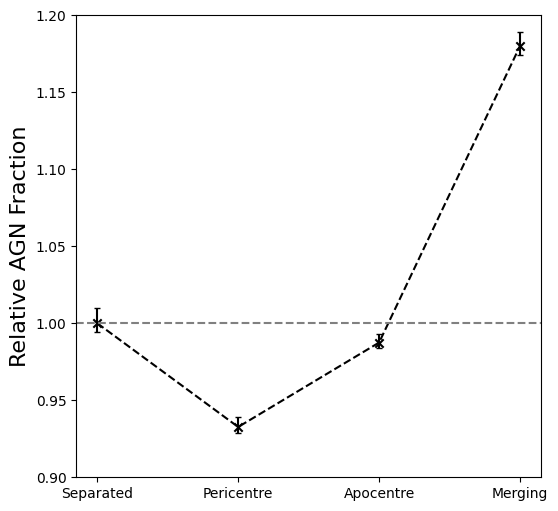

In [186]:
plt.figure(figsize = (6,6))
plt.scatter(x, all_fracts / all_fracts[0] , color = 'black', marker = 'x')
plt.plot(x, all_fracts / all_fracts[0], color = 'black', linestyle='--')
plt.axhline(1.0, color = 'gray', linestyle = '--')
plt.errorbar(x, all_fracts / all_fracts[0], yerr=agn_frac_err.T, linestyle = '', color='black', barsabove=True, capsize=2.5)
plt.ylim([0.90,1.20])
plt.ylabel('Relative AGN Fraction', fontsize = 16)
plt.savefig(f'{fig_folder}/relative-agn-fraction.pdf', dpi=720, bbox_inches = 'tight')
plt.show()